### Scrambling Sentences in Different GLUE tasks
This file helps you scramble sentences in different tasks.

In [100]:
# imports
from vocab_mismatch_utils import *
from data_formatter_utils import *
from datasets import DatasetDict
from datasets import Dataset
from datasets import load_dataset
import transformers
import pandas as pd
import operator
from collections import OrderedDict
from tqdm import tqdm, trange

import collections
import os
import unicodedata
from typing import List, Optional, Tuple

from transformers.tokenization_utils import PreTrainedTokenizer, _is_control, _is_punctuation, _is_whitespace
from transformers.utils import logging
import torch
logger = logging.get_logger(__name__)
import numpy as np
import copy
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from word_forms.word_forms import get_word_forms
from functools import partial
import matplotlib.ticker as mticker

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 20}
plt.rc('font', **font)

FILENAME_CONFIG = {
    "sst3" : "sst-tenary",
    "cola" : "cola",
    "mnli" : "mnli",
    "snli" : "snli",
    "mrpc" : "mrpc",
    "qnli" : "qnli"
}
TASK_CONFIG = {
    "sst3": ("text", None),
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "snli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence")
}

Inline Helper Functions

In [116]:
# this tokenizer helps you to get piece length for each token
modified_tokenizer = ModifiedBertTokenizer(
    vocab_file="../data-files/bert_vocab.txt")
modified_basic_tokenizer = ModifiedBasicTokenizer()

def token_stats_mapping(task, example):
    # for tasks that have single sentence
    if task == "sst3" or task == "wiki-text" or task == "cola":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            if len(original_sentence.strip()) != 0:
                tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
                for token, pieces in token_dict.items():
                    if token in token_frequency_map.keys():
                        token_frequency_map[token] = token_frequency_map[token] + 1
                    else:
                        token_frequency_map[token] = 1
                    _len = len(pieces)
                    if _len in token_by_length.keys():
                        if token not in token_by_length[_len]:
                            token_by_length[_len].append(token)
                    else:
                        token_by_length[_len] = [token]
    # for tasks that have two sentences
    elif task == "mrpc" or task == "mnli" or task == "snli" or task == "qnli":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
                
        original_sentence = example[TASK_CONFIG[task][1]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            tokens, token_dict = modified_tokenizer.tokenize(original_sentence)
            for token, pieces in token_dict.items():
                if token in token_frequency_map.keys():
                    token_frequency_map[token] = token_frequency_map[token] + 1
                else:
                    token_frequency_map[token] = 1
                _len = len(pieces)
                if _len in token_by_length.keys():
                    if token not in token_by_length[_len]:
                        token_by_length[_len].append(token)
                else:
                    token_by_length[_len] = [token]
    else:
        print(f"task={task} not supported yet!")
    return example

def generate_vocab_match_no_frequency_iv(token_by_length, token_frequency_map):
    vocab_match = {}
    tokens = list(task_token_frequency_map.keys())
    tokens_copy = copy.deepcopy(tokens)
    random.shuffle(tokens_copy)
    for i in range(len(tokens)):
        vocab_match[tokens[i]] = tokens_copy[i]
    return vocab_match

def generate_vocab_match_frequency_iv(token_by_length, token_frequency_map):
    vocab_match = {}
    for _, tokens in token_by_length.items():
        tokens_copy = copy.deepcopy(tokens)
        
        # token_frequency_map, token_lemma_map)
        
        token_freq_tu = []
        for t in tokens:
            token_freq_tu.append((t, token_frequency_map[t]))
        token_freq_tu = sorted(token_freq_tu, key=operator.itemgetter(1), reverse=True)
        
        matched_to = set([])
        for i in trange(0, len(token_freq_tu)):
            found = False
            for j in range(0, len(token_freq_tu)):
                word_i = token_freq_tu[i][0]
                word_j = token_freq_tu[j][0]
                if i != j and word_j not in matched_to and \
                    levenshteinDistance(word_i, word_j) > 0.3:
                    matched_to.add(word_j)
                    vocab_match[word_i] = word_j
                    found = True
                    break
            if not found:
                vocab_match[word_i] = word_i
            
    return vocab_match

def generate_vocab_match_abstract(token_frequency_map):
    vocab_match = {}
    vocab_list = []
    for k,v in token_frequency_map.items():
        vocab_list.append(k)
    random.shuffle(vocab_list)
    abstract_matches = []
    for i in range(0, 4):
        az_list = []
        for j in range(ord('a'), ord('z')+1):
            az_list.append(chr(j))
        abstract_matches.append(az_list)
    from itertools import product
    abstract_matches = product(*abstract_matches)
    abstract_english_pool = []
    for match in abstract_matches:
        abstract_english_pool.append("".join(match))
    for i in range(0, len(vocab_list)):
        vocab_match[vocab_list[i]] = abstract_english_pool[i]
    return vocab_match

def random_corrupt(task, tokenizer, vocab_match, example):
    # for tasks that have single sentence
    if task == "sst3" or task == "wiki-text" or task == "cola":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            corrupted_sentence = corrupt_translator(original_sentence, tokenizer, vocab_match)
            example[TASK_CONFIG[task][0]] = corrupted_sentence
    # for tasks that have two sentences
    elif task == "mrpc" or task == "mnli" or task == "snli" or task == "qnli":
        original_sentence = example[TASK_CONFIG[task][0]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            corrupted_sentence = corrupt_translator(original_sentence, tokenizer, vocab_match)
            example[TASK_CONFIG[task][0]] = corrupted_sentence
        
        original_sentence = example[TASK_CONFIG[task][1]]
        if original_sentence != None and original_sentence.strip() != "" and original_sentence.strip() != "None":
            corrupted_sentence = corrupt_translator(original_sentence, tokenizer, vocab_match)
            example[TASK_CONFIG[task][1]] = corrupted_sentence
    else:
        print(f"task={task} not supported yet!")
    return example

def plot_dist(vocab, map1, map2, facecolor='b', post_fix="mismatched"):
    freq_diff = []
    for k, v in vocab.items():
        diff = abs(map1[k] - map2[v])
        # print(diff)
        freq_diff.append(diff)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    g = ax.hist(freq_diff, bins=50, facecolor=facecolor, alpha=0.5)
    plt.grid(True)
    plt.grid(color='black', linestyle='-.')
    import matplotlib.ticker as mtick
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    ax.set_yscale('log')
    plt.xlabel(f"Difference in Frequencies ({post_fix})")
    # plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ylabel("Frequency (Count)")
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.0e'))
    plt.tight_layout()
    plt.show()

#### Wiki-Text Frequency for OOV

If you want to explore out-of-task vocab swapping, you can look into these lines of code!

In [39]:
wiki = False # turn it on if you want to run. It will take a long time to finish.
if wiki:
    wiki_datasets = DatasetDict.load_from_disk(os.path.join(external_output_dirname, "wikitext-15M"))
    wiki_train_df = wiki_datasets['train']
    wiki_eval_df = wiki_datasets['validation']
    wiki_test_df = wiki_datasets['test']

    token_frequency_map = {} # overwrite this everytime for a new dataset
    wiki_train_df = wiki_train_df.map(partial(token_frequency_mapping, "wiki-text"))
    wiki_eval_df = wiki_eval_df.map(partial(token_frequency_mapping, "wiki-text"))
    wiki_test_df = wiki_test_df.map(partial(token_frequency_mapping, "wiki-text"))
    token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True) # copy
    wiki_token_frequency_map = OrderedDict(token_frequency_map)

### Get mismatched vocab!
Simply set your task name below for new tasks! Be sure to have your dataset downloaded into the right folder!

In [186]:
# task setups
task_name = "snli"
# random seeds
# WARNING: this may change your results as well. Try it a few different seeds.
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

##### Step 1: Get frequency distribution of the dataset.

Note that we are cheating here a little bit. For tasks that have a pair of sentences, we consider the word frequency all together for both sentences. This is the worst case scenario as well, since two sentences may have different vocab distributions! If this works, we are confident more fine-grained scrambling should work.

In [187]:
# let us corrupt SST3 in the same way as before
train_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                    f"{FILENAME_CONFIG[task_name]}-train.tsv"), 
                       delimiter="\t")
eval_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                   f"{FILENAME_CONFIG[task_name]}-dev.tsv"), 
                      delimiter="\t")
test_df = pd.read_csv(os.path.join(external_output_dirname, FILENAME_CONFIG[task_name], 
                                   f"{FILENAME_CONFIG[task_name]}-test.tsv"), 
                      delimiter="\t")

train_df = Dataset.from_pandas(train_df)
eval_df = Dataset.from_pandas(eval_df)
test_df = Dataset.from_pandas(test_df)

token_by_length = {} # overwrite this everytime for a new dataset
token_frequency_map = {} # overwrite this everytime for a new dataset
train_df = train_df.map(partial(token_stats_mapping, task_name))
eval_df = eval_df.map(partial(token_stats_mapping, task_name))
test_df = test_df.map(partial(token_stats_mapping, task_name))
task_token_by_length = OrderedDict(token_by_length)
task_token_frequency_map = sorted(token_frequency_map.items(), key=operator.itemgetter(1), reverse=True)
task_token_frequency_map = OrderedDict(task_token_frequency_map)

##### Step 2(a): Frequency matched in-vocab swap

100%|██████████| 1/1 [00:00<00:00, 4733.98it/s]


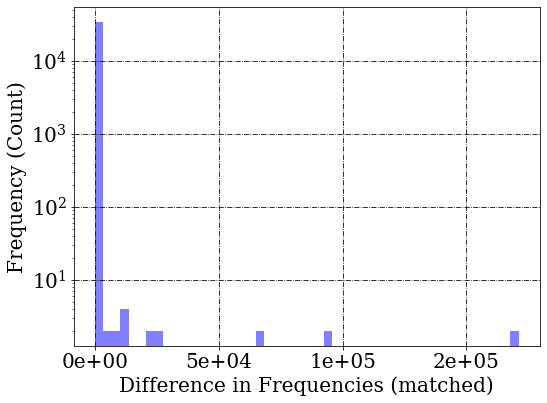

In [189]:
# mismatch script
vocab_match_frequency_iv = \
    generate_vocab_match_frequency_iv(task_token_by_length, 
                                      task_token_frequency_map)
# plot the frequency distribution afterwards (the diff)
plot_dist(vocab_match_frequency_iv, task_token_frequency_map, task_token_frequency_map, 
          facecolor='b', post_fix="matched")

In [151]:
# write to the disk if things looking good!
corrupted_train_dataset = train_df.map(partial(random_corrupt, 
                                               task_name,
                                               modified_basic_tokenizer, 
                                               vocab_match_frequency_iv))
corrupted_validation_dataset = eval_df.map(partial(random_corrupt, 
                                                   task_name,
                                                   modified_basic_tokenizer, 
                                                   vocab_match_frequency_iv))
corrupted_test_dataset = test_df.map(partial(random_corrupt, 
                                             task_name,
                                             modified_basic_tokenizer, 
                                             vocab_match_frequency_iv))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-matched")

In [198]:
# pick out an example sentence to show the scrambling.
example = train_df[random.randint(0, len(train_df)-1)]
for name in TASK_CONFIG[task_name]:
    if name != None:
        example_sentence = example[name]
        print(f"original {name}: {example_sentence}")
        corrupted = corrupt_translator(example_sentence, modified_basic_tokenizer, vocab_match_frequency_iv)
        print(f"scrambled {name}: {corrupted}")

original premise: A lady wearing a Batman shirt is walking along the boardwalk.
scrambled premise: . car , . peach playing the outside hands is lay a
original hypothesis: A woman is swimming in a lake.
scrambled hypothesis: . with the baseball man . helmet a


##### Step 2(a): Frequency mis-matched in-vocab swap

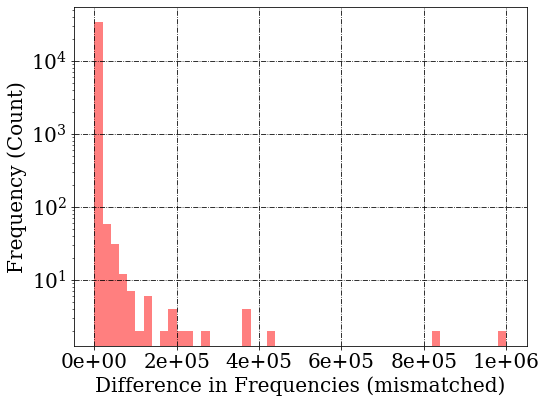

In [190]:
# mismatch script
vocab_match_no_frequency_iv = \
    generate_vocab_match_no_frequency_iv(task_token_by_length, 
                                       task_token_frequency_map)
# plot the frequency distribution afterwards (the diff)
plot_dist(vocab_match_no_frequency_iv, task_token_frequency_map, task_token_frequency_map, 
          facecolor='r', post_fix="mismatched")

In [154]:
# write to the disk if things looking good!
corrupted_train_dataset = train_df.map(partial(random_corrupt, 
                                               task_name,
                                               modified_basic_tokenizer, 
                                               vocab_match_no_frequency_iv))
corrupted_validation_dataset = eval_df.map(partial(random_corrupt, 
                                                   task_name,
                                                   modified_basic_tokenizer, 
                                                   vocab_match_no_frequency_iv))
corrupted_test_dataset = test_df.map(partial(random_corrupt, 
                                             task_name,
                                             modified_basic_tokenizer, 
                                             vocab_match_no_frequency_iv))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-mismatched")

In [200]:
# pick out an example sentence to show the scrambling.
for name in TASK_CONFIG[task_name]:
    if name != None:
        example_sentence = example[name]
        print(f"original {name}: {example_sentence}")
        corrupted = corrupt_translator(example_sentence, modified_basic_tokenizer, vocab_match_no_frequency_iv)
        print(f"scrambled {name}: {corrupted}")
        unordered = corrupted.split(" ")
        random.shuffle(unordered)
        unordered = " ".join(unordered)
        print(f"reordered scrambled {name}: {unordered}")
        

original premise: A lady wearing a Batman shirt is walking along the boardwalk.
scrambled premise: moist cleaver surf moist blades smurf hover bugger unto locals pinnies cotton
reordered scrambled premise: cleaver blades hover moist cotton locals unto bugger moist pinnies smurf surf
original hypothesis: A woman is swimming in a lake.
scrambled hypothesis: moist songs hover starves blacktop moist beam cotton
reordered scrambled hypothesis: blacktop cotton songs moist hover beam starves moist


##### Step 3. Not Even Word, Go Symbolic

In [191]:
# mismatch script
vocab_match_abstract = \
    generate_vocab_match_abstract(task_token_frequency_map)

In [157]:
# write to the disk if things looking good!
corrupted_train_dataset = train_df.map(partial(random_corrupt, 
                                               task_name,
                                               modified_basic_tokenizer, 
                                               vocab_match_abstract))
corrupted_validation_dataset = eval_df.map(partial(random_corrupt, 
                                                   task_name,
                                                   modified_basic_tokenizer, 
                                                   vocab_match_abstract))
corrupted_test_dataset = test_df.map(partial(random_corrupt, 
                                             task_name,
                                             modified_basic_tokenizer, 
                                             vocab_match_abstract))

corrupted_datasets = DatasetDict({"train":corrupted_train_dataset, 
                                  "validation":corrupted_validation_dataset, 
                                  "test":corrupted_test_dataset})
corrupted_datasets.save_to_disk(f"../data-files/{FILENAME_CONFIG[task_name]}-corrupted-abstract")

In [201]:
# pick out an example sentence to show the scrambling.
for name in TASK_CONFIG[task_name]:
    if name != None:
        example_sentence = example[name]
        print(f"original {name}: {example_sentence}")
        corrupted = corrupt_translator(example_sentence, modified_basic_tokenizer, vocab_match_abstract)
        print(f"scrambled {name}: {corrupted}")

original premise: A lady wearing a Batman shirt is walking along the boardwalk.
scrambled premise: bwcc apwa aleq bwcc bstw bjqg aqrv bpgv blin aisp berv akex
original hypothesis: A woman is swimming in a lake.
scrambled hypothesis: bwcc ajux aqrv ainl ahel bwcc bjaz akex


##### Playground

In [ ]:
# anything you want to demo!